# Report 5

# Part 1

In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import KNeighborsClassifier
from statistics import mean

## 1) Data inspection

In [136]:
#reading the csv file
df = pd.read_csv("/Users/simonegalota/Desktop/log_tcp_complete_classes.txt", sep=" ")

#### How many TCP connections (bi-directional flows) does the log contain?


In [137]:
tot_conn = len(df)
print(f"The number of total TCP Connections is: {tot_conn}")

The number of total TCP Connections is: 100000


#### How many classes (web services) does the log contain? Can you list all of them? How many connections per web service are there?


In [138]:
classLabel = df["class:207"].unique()
print(f"The classes are: {classLabel}")
print(f"The number of classes is: {len(classLabel)}")

connectionsPerService = df.groupby("class:207").size().sort_values(ascending=False)
print(connectionsPerService)

The classes are: ['class:google' 'class:bing' 'class:linkedin' 'class:instagram'
 'class:youtube' 'class:netflix' 'class:spotify' 'class:facebook'
 'class:ebay' 'class:amazon']
The number of classes is: 10
class:207
class:amazon       10000
class:bing         10000
class:ebay         10000
class:facebook     10000
class:google       10000
class:instagram    10000
class:linkedin     10000
class:netflix      10000
class:spotify      10000
class:youtube      10000
dtype: int64


#### Which of these columns do you, as a network engineer, think can help predict the service visited? Discuss the most important ones in your opinion.

The features we selected, which we think can help predict the service, are the followings:

In [139]:
selected_features=['con_t:42',
 's_pktsize1:165',
 'c_pkts_all:3',
 'c_rst_cnt:4',
 'c_ack_cnt:5',
 'c_ack_cnt_p:6',
 'c_bytes_uniq:7',
 'c_pkts_data:8',
 'c_bytes_all:9',
 'c_pkts_retx:10',
 'c_bytes_retx:11',
 'c_pkts_ooo:12',
 'c_syn_cnt:13',
 'c_fin_cnt:14',
 's_pkts_all:17',
 's_rst_cnt:18',
 's_ack_cnt:19',
 's_ack_cnt_p:20',
 's_bytes_uniq:21',
 's_pkts_data:22',
 's_bytes_all:23',
 'c_msgsize1:132', 
 's_msgsize_count:142',
 'c_pktsize1:154',
 'c_sit1:175',
 's_sit1:184']

The connection type field could be massively useful, as each service could use a different level 7 protocol, so we decided to use it to predict it. Also, the size of the packets' payloads exchanged between server and client could be a fingerprint to recognize the service used. We have to say that columns expressing number of bytes are very useful to predict the service. Because there could be a huge difference between data exchanged by client and server in different services. For instance, a service like YouTube will have a big amount of data transmitted from server to client, especially if video are seen in high quality. Instead a message based service will transmitt less data compared to YouTube, even if multimedia content are exchanged (because they are usually compressed in order to send the least amount of data).
However, we have chosen different coloumns because with these features, the overall classification is more accurate.

## 2) Data cleaning

In [140]:
#First, we delete the columns of the DataFrame we cannot use for the prediction 
columns_to_delete = ["#31#c_ip:1", "c_port:2", "s_ip:15", "s_port:16", "c_tls_SNI:116", "s_tls_SCN:117", "fqdn:127"]
df = df.drop(columns_to_delete, axis=1)

## 3) Data splitting

In [141]:
#Separate features and label
X = df[selected_features]
y = df['class:207']

#split dataset into train and test sets
(X_train, X_test, y_train, y_test )= train_test_split(X, y, test_size=0.25, random_state = 68)

## 4) Data preprocessing

In [142]:
#Separate categorical features and numerical ones; also, put the first ones in DataFrames to give to the OneHotEncoder
#We do it both for training and test set, to be ready to use the latter in part 8
X_train_c=X_train[['con_t:42']]
X_train_n=X_train.drop("con_t:42", axis=1)
X_test_c=X_test[['con_t:42']]
X_test_n=X_test.drop("con_t:42", axis=1)

In [143]:
#OneHotEncoder preprocessing on categorical features
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(X_train_c)
X_train_c = enc.transform(X_train_c)
X_test_c = enc.transform(X_test_c)

In [144]:
#Rejoin categorical and numerical features, to give them all to the Standard Scaler
df1 = pd.DataFrame(X_train_c.toarray())
df1 = df1.reset_index(drop=True)
df2 = pd.DataFrame(X_test_c.toarray())
df2 = df2.reset_index(drop=True)
X_train_n = X_train_n.reset_index(drop=True)
X_test_n = X_test_n.reset_index(drop=True)
df_ss_train = X_train_n.join(df1)
df_ss_test = X_test_n.join(df2)

#Standard Scaler preprocessing on all the features
scaler = StandardScaler()
scaler.fit(df_ss_train)
X_train = scaler.transform(df_ss_train)
X_test = scaler.transform(df_ss_test)

#### Comment on the process for both the one-hot encoding and scaling. How does the standard scaler work? Is that appropriate for our problem in your opinion?


Data might behave badly if the individual features do not look like standard normally distributed data, namely a Gaussian curve with zero mean and unit variance. Hence, often we just transform the data to center it by removing the mean value of each feature, then scale it by dividing non-constant features by their standard deviation, obtaining a zero mean-value and a unit standard deviation. A Standard Scaler does exactly this, transforming input rows in order to normalize each feature and have unit standard deviation and/or zero mean.



## 5) Train at least two different models

#### How much does it take to train the model (time in seconds), for the different algorithm and parameters? What and why there is the difference between them?

In [145]:
import time

#Classification: we chose to apply the Decision Tree and Random Forest Classifiers.
clf = tree.DecisionTreeClassifier()

#We exploit the time library to compute the time required to train the two models
start = time.time()
clf = clf.fit(X_train, y_train.ravel())
end = time.time()
print(end - start)

1.0658152103424072


In [146]:
clf2 = RandomForestClassifier(n_estimators=10)

start = time.time()
clf2 = clf2.fit(X_train, y_train.ravel())
end = time.time()
print(end - start)

1.463352918624878


In our specific case (decision tree vs random forest), there is a difference in terms of execution time needed because the decision tree combines some decisions, whereas a random forest combines several decision trees. Moreover, using the random forest classifier the time increases if the number of estimators is incremented.

## 6) Evaluate the performance of the models (on training and cross-validation)

In [147]:
#Accuracy score computed on the prediction of the first model (DecisionTreeClassifier)
y_pred = clf.predict(X_train)
accuracy_score(y_pred,y_train)

0.9511333333333334

In [148]:
#Confusion matrix computed on the prediction of the first model (DecisionTreeClassifier)
#labels=['google','bing', 'linkedin', 'instagram','youtube', 'netflix', 'spotify', 'facebook','ebay','amazon']
print(classLabel)
confusion_matrix(y_train, y_pred, labels=classLabel)

['class:google' 'class:bing' 'class:linkedin' 'class:instagram'
 'class:youtube' 'class:netflix' 'class:spotify' 'class:facebook'
 'class:ebay' 'class:amazon']


array([[7131,    0,    2,    1,   26,   46,    8,    0,  250,    0],
       [   1, 7439,   11,    0,    1,   50,    2,    0,   17,    0],
       [  10,    1, 7085,    0,   15,  105,    8,    0,  289,    5],
       [   4,    0,    0, 7333,    1,   73,    4,   39,   71,    2],
       [  20,    1,    0,    0, 6763,  110,    5,    0,  643,    2],
       [   2,    0,    5,    0,   12, 7224,    9,    1,  288,    4],
       [   3,    0,    1,    0,    1,   11, 7203,    3,  207,    1],
       [   0,    0,    1,    1,    7,   23,    3, 7188,  326,    1],
       [   2,    0,   13,    0,   25,  171,    0,    2, 7229,    4],
       [   0,    0,    7,    0,    2,   72,    0,    0,  634, 6740]])

In [149]:
#Accuracy score computed on the prediction of the second model (RandomForestClassifier)
y_pred2 = clf2.predict(X_train)
accuracy_score(y_pred2, y_train)

0.94936

In [150]:
#Confusion matrix computed on the prediction of the second model (RandomForestClassifier)
print(classLabel)
confusion_matrix(y_train, y_pred2, labels=classLabel)

['class:google' 'class:bing' 'class:linkedin' 'class:instagram'
 'class:youtube' 'class:netflix' 'class:spotify' 'class:facebook'
 'class:ebay' 'class:amazon']


array([[7121,    2,    4,    1,   30,   46,   10,    1,  246,    3],
       [   1, 7432,   12,    0,    1,   51,    2,    0,   19,    3],
       [  13,    1, 7088,    0,   15,  108,    8,    0,  280,    5],
       [   5,    0,    1, 7342,    1,   73,    5,   27,   71,    2],
       [  45,    4,    3,    0, 6725,  110,    6,    3,  643,    5],
       [   3,    0,   10,    0,   12, 7217,   10,    2,  289,    2],
       [   1,    2,    4,    0,    1,   15, 7195,    3,  207,    2],
       [   1,    0,    1,   24,    8,   23,    3, 7164,  325,    1],
       [   8,    1,   22,    0,   25,  172,    0,    2, 7195,   21],
       [   2,    2,   12,    1,    2,   74,    0,    2,  637, 6723]])

#### Comment on the different performance reached in each class. Which web service is easier to detect? Which one is harder? Why do you think that is?


The web service easier to detect is bing.com, whereas the harder is youtube. We think that depend massively on the features selected. But after several tries, we have reached a good trade-off with the ones chosen at the ends.

### Cross validation

In [151]:
#In the following code we implement the 3-Fold cross validation on the first model (DecisionTreeClassifier).
#We split the training data and validation data manually, leveraging the KFold function of the sklearn.model_selection library
#1/3 of data will be the validation set, 2/3 the training set. They're different data for each iteration.
#In each iteration, we train the model on the training data and test it on the validation data.
#And we compute the f1_score of the prediction, comparing it to the real labels of each validation set
y_train = pd.DataFrame(y_train).to_numpy()
kf = KFold(n_splits=3)
for train_index, val_index in kf.split(X_train):
    X_trainV, y_trainV = X_train[train_index], y_train[train_index]
    X_val, y_val = X_train[val_index], y_train[val_index]
    clf.fit(X_trainV, y_trainV.ravel())
    y_pred=clf.predict(X_val)
    print(f1_score(y_val, y_pred, average='macro'))
    print("%s %s" % (len(train_index), len(val_index)))

0.8709408445481502
50000 25000
0.8735598220436118
50000 25000
0.8725887292397495
50000 25000


In [152]:
#Same thing, but we implement the 5-fold cross validation this time, again on the first model (DecisionTreeClassifier).
kf = KFold(n_splits=5)
for train_index, val_index in kf.split(X_train):
    X_trainV, y_trainV = X_train[train_index], y_train[train_index]
    X_val, y_val = X_train[val_index], y_train[val_index]
    clf.fit(X_trainV, y_trainV.ravel())
    y_pred=clf.predict(X_val)
    print(f1_score(y_val, y_pred, average='macro'))
    print("%s %s" % (len(train_index), len(val_index)))

0.8769045717069943
60000 15000
0.8812643496593331
60000 15000
0.8788085082161377
60000 15000
0.8771063311656281
60000 15000
0.8777542269497106
60000 15000


In [153]:
#Same process for the 3-Fold cross validation, but on the second model (RandomForestClassifier)
kf = KFold(n_splits=3)
for train_index, val_index in kf.split(X_train):
    X_trainV, y_trainV = X_train[train_index], y_train[train_index]
    X_val, y_val = X_train[val_index], y_train[val_index]
    clf2.fit(X_trainV, y_trainV.ravel())
    y_pred=clf2.predict(X_val)
    print(f1_score(y_val, y_pred, average='macro'))
    print("%s %s" % (len(train_index), len(val_index)))

0.8825442642723947
50000 25000
0.8820591773933663
50000 25000
0.8805882653492588
50000 25000


In [154]:
#5-Fold cross validation on the second model (RandomForestClassifier)
kf = KFold(n_splits=5)
for train_index, val_index in kf.split(X_train):
    X_trainV, y_trainV = X_train[train_index], y_train[train_index]
    X_val, y_val = X_train[val_index], y_train[val_index]
    clf2.fit(X_trainV, y_trainV.ravel())
    y_pred=clf2.predict(X_val)
    print(f1_score(y_val, y_pred, average='macro'))
    print("%s %s" % (len(train_index), len(val_index)))

0.8878496134090019
60000 15000
0.8909947695710331
60000 15000
0.8857012695083588
60000 15000
0.8848109149384088
60000 15000
0.8868323216725902
60000 15000


#### How many samples are in each training set and test set for the 3-fold case? What about the 5-fold? Which one do you think gives a more realistic performance evaluation?

We printed the length of the train_index and val_index (in the code above) in order to calculate how many samples there are in each sets. 
In the 3-fold case, we take 1/3 of the data as validation set and 2/3 as training set. Instead in the 5-fold case, we do training on 4/5 of the data (4/5 > 1/3), so we can suppose that it gives us more realistic perfomance evaluation.

## 7) Tune the parameters of the models

#### Report a table (or a heatmap) with the results from the grid search. What is the mean accuracy over all folds for each combination of parameters? Which is the best combination of parameters the grid search has found? How long did the grid search take? What do you think can be a way to speed up the parameter search?

In [155]:
#We exploit the GridSearchCV function to perform the parameters tuning, which means to train the model trying all possible
#combinations of the given parameters. The function return the best model, which we can fit on our training set and which 
#gives us the best parameters among the given ones. It's done on the DecisionTreeClassifier this time.
param_grid_dt = {'max_depth': [2, 5, 10], 'min_impurity_decrease': [0.0, 0.2, 0.5]}
grid_search1 = GridSearchCV(clf, param_grid_dt) # Grid search fa cross validation
grid_search1.fit(X_train, y_train.ravel())
print("The best parameters are %s with a score of %0.2f"% (grid_search1.best_params_, grid_search1.best_score_))

The best parameters are {'max_depth': 10, 'min_impurity_decrease': 0.0} with a score of 0.76


In [156]:
#Same thing, but on the RandomForestClassifier
param_grid_rf = {'n_estimators': [10, 50, 100], 'max_depth': [2, 5, 10]}
grid_search2 = GridSearchCV(clf2, param_grid_rf)
grid_search2.fit(X_train, y_train.ravel())
print("The best parameters are %s with a score of %0.2f"% (grid_search2.best_params_, grid_search2.best_score_))

The best parameters are {'max_depth': 10, 'n_estimators': 100} with a score of 0.80


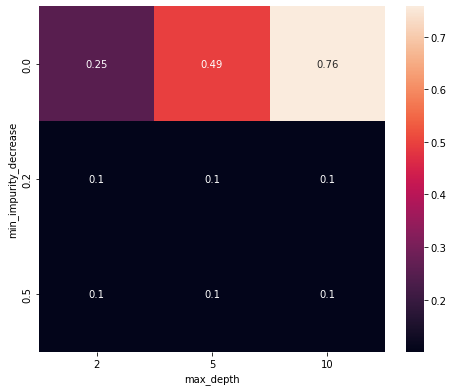

In [157]:
#Heatmap with the results of the grid search for the first model.
plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=0.2, right=0.95, bottom=0.15, top=0.95)
C_range = np.logspace(0, 8, 9)
gamma_range = np.logspace(0, 8, 9)
params = grid_search1.cv_results_['params']
scores = grid_search1.cv_results_['mean_test_score']
df = pd.DataFrame(params)
df["scores"] = scores
table = pd.pivot_table(df, 'scores', 'min_impurity_decrease', 'max_depth')
heatmap = sns.heatmap(table, annot=True)

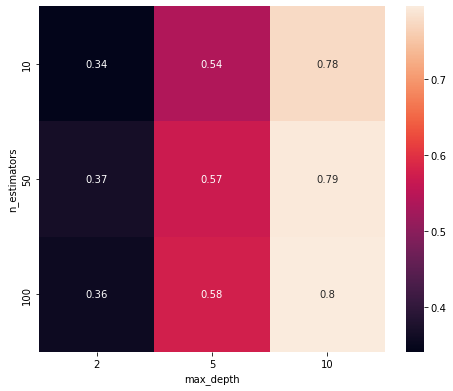

In [158]:
#Heatmap with the results of the grid search for the second model.
plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=0.2, right=0.95, bottom=0.15, top=0.95)
C_range = np.logspace(0, 8, 9)
gamma_range = np.logspace(0, 8, 9)
params = grid_search2.cv_results_['params']
scores = grid_search2.cv_results_['mean_test_score']
df = pd.DataFrame(params)
df["scores"] = scores
table = pd.pivot_table(df, 'scores', 'n_estimators', 'max_depth')
heatmap = sns.heatmap(table, annot=True)

## 8) Return the best possible model and estimate its performance on new data

In [159]:
#Having the best parameters, we apply them to a new RandomForestClassifier and then train it on the test set.
clf_final = RandomForestClassifier(n_estimators=50, max_depth=10)
clf_final = clf_final.fit(X_train, y_train.ravel())
#Now we can make the prediction on the test data.
y_pred = clf_final.predict(X_test)

In [160]:
#Accuracy score on the prediction on test data by the final model.
accuracy_score(y_pred, y_test)

0.79984

In [161]:
#Confusion matrix on the prediction on test data by the final model.
print(classLabel)
confusion_matrix(y_test, y_pred, labels=classLabel)

array([[1948,   60,   24,   37,  236,   31,    5,   30,  102,   63],
       [   2, 2296,   29,    6,    4,   51,    5,    1,   41,   44],
       [   4,    9, 1747,   93,   75,  220,    0,   70,  184,   80],
       [  20,   11,   11, 2257,   10,   32,    8,   96,   22,    6],
       [ 147,   41,   17,   54, 1899,   36,    1,   32,  218,   11],
       [   4,    3,   54,   68,   26, 2165,    4,   10,  111,   10],
       [   7,   17,  132,   56,   27,   88, 2048,   89,   85,   21],
       [   7,   18,   45,  469,   44,   26,    4, 1728,  103,    6],
       [   4,   70,   72,   63,   17,  108,    6,   10, 2077,  127],
       [   9,   19,   80,   91,   57,   44,    1,   31,  382, 1831]])

In [162]:
#f1_score on the prediction on test data by the final model.
f1_score(y_test, y_pred, average='macro') 

0.8012107232368605

#### Does it perform better or worse than the training set? What about the validation sets? Comment on the results and all the process. What are the most important takeaways from doing the pipeline?

Obviously it performs worse than training set: in this case we have an acccuracy of 79% rather than the accuracy of 95% with the training set. Also, if compared with the validation sets the performance is worse (80% against 87%). 
At last, we can say that our Machine Learning model did not perform badly with the prediction on data which it has never seen before (test data), as the perfomance evaluation shows. The prediction is not perfect, but around 80% of data have been correctly predicted. 

# Part 2

In [163]:
df = pd.read_csv("/Users/simonegalota/Desktop/log_tcp_complete_classes.txt", sep=" ")

In [164]:
selected_features_regression=['con_t:42',
 's_pktsize1:165',
 'c_pkts_all:3',
 'c_rst_cnt:4',
 'c_ack_cnt:5',
 'c_ack_cnt_p:6',
 'c_bytes_uniq:7',
 'c_pkts_data:8',
 'c_bytes_all:9',
 'c_pkts_retx:10',
 'c_bytes_retx:11',
 'c_pkts_ooo:12',
 'c_syn_cnt:13',
 'c_fin_cnt:14',
 's_pkts_all:17',
 's_rst_cnt:18',
 's_ack_cnt:19',
 's_ack_cnt_p:20',
 's_bytes_uniq:21',
 's_pkts_data:22',
 'c_msgsize1:132', 
 's_msgsize_count:142',
 'c_pktsize1:154',
 'c_pktsize2:155',
 'c_pktsize3:156',
 'c_sit1:175',
 's_sit1:184']

In [165]:
columns_to_delete = ["#31#c_ip:1", "c_port:2", "s_ip:15", "s_port:16", "c_tls_SNI:116", "s_tls_SCN:117", "fqdn:127"]
df = df.drop(columns_to_delete, axis=1)

In [166]:
#split in training e test set
X = df[selected_features_regression]
y1 = df['s_bytes_all:23']
y2 = df['s_rtt_avg:52']
(X_train1, X_test1, y_train1, y_test1 )= train_test_split(X, y1, test_size=0.25, random_state = 0)
(X_train2, X_test2, y_train2, y_test2 )= train_test_split(X, y2, test_size=0.25, random_state = 0)

In [167]:
#separazione in attributi categorici e non
X_train_c1=X_train1[['con_t:42']]
X_train_n1=X_train1.drop("con_t:42", axis=1)
X_train_c2=X_train2[['con_t:42']]
X_train_n2=X_train2.drop("con_t:42", axis=1)
X_test_c1=X_test1[['con_t:42']]
X_test_n1=X_test1.drop("con_t:42", axis=1)
X_test_c2=X_test2[['con_t:42']]
X_test_n2=X_test2.drop("con_t:42", axis=1)

In [168]:
#OneHotEncoder
enc1 = OneHotEncoder(handle_unknown='ignore')
enc1.fit(X_train_c1)
enc2 = OneHotEncoder(handle_unknown='ignore')
enc2.fit(X_train_c2)
X_train_c1 = enc1.transform(X_train_c1)
X_test_c1 = enc1.transform(X_test_c1)
X_train_c2 = enc2.transform(X_train_c2)
X_test_c2 = enc2.transform(X_test_c2)

In [169]:
#rimettiamo i pezzi insieme
df1 = pd.DataFrame(X_train_c1.toarray())
df1 = df1.reset_index(drop=True)
df2 = pd.DataFrame(X_test_c1.toarray())
df2 = df2.reset_index(drop=True)
X_train_n1 = X_train_n1.reset_index(drop=True)
X_test_n1 = X_test_n1.reset_index(drop=True)

df3 = pd.DataFrame(X_train_c2.toarray())
df3 = df3.reset_index(drop=True)
df4 = pd.DataFrame(X_test_c2.toarray())
df4 = df4.reset_index(drop=True)
X_train_n2 = X_train_n2.reset_index(drop=True)
X_test_n2 = X_test_n2.reset_index(drop=True)

df_ss_train1 = X_train_n1.join(df1)
df_ss_test1 = X_test_n1.join(df2)
df_ss_train2 = X_train_n2.join(df3)
df_ss_test2 = X_test_n2.join(df4)

In [170]:
#Standard Scaler
scaler1 = StandardScaler()
scaler1.fit(df_ss_train1)
X_train1 = scaler1.transform(df_ss_train1)
X_test1 = scaler1.transform(df_ss_test1)
scaler2 = StandardScaler()
scaler2.fit(df_ss_train2)
X_train2 = scaler2.transform(df_ss_train2)
X_test2 = scaler2.transform(df_ss_test2)

In [171]:
#Linear Regression
clf_r1 = tree.DecisionTreeRegressor()
clf_r1.fit(X_train1, y_train1)
y_pred1 = clf_r1.predict(X_test1)

In [172]:
clf_r2 = tree.DecisionTreeRegressor()
clf_r2.fit(X_train2, y_train2)
y_pred2 = clf_r2.predict(X_test2)

#### Which of the two problems gives a higher Mean Absolute Error? What is the error measured in (unit)? Which performs better in your opinion?

In [173]:
mae1 = mean_absolute_error(y_test1, y_pred1)
print(f"The mean absolute error for s_bytes_all:23 is: %.2f"% mae1+"KB")

The mean absolute error for s_bytes_all:23 is: 15337.19KB


In [174]:
mae2 = mean_absolute_error(y_test2, y_pred2)
print(f"The mean absolute error for rtt_avg:52 is: %.2f"% mae2+"ms")

The mean absolute error for rtt_avg:52 is: 51.61ms


In [175]:
avg_y_test1 = mean(y_test1) #we compute the average value of the y_test1 in order to retrieve the relative error
err1 = (mae1/avg_y_test1) * 100
print(f"The relative error for s_bytes_all:23 is: %.2f"% err1+"%")

The relative error for s_bytes_all:23 is: 10.43%


In [176]:
avg_y_test2 = mean(y_test2) #we compute the average value of the y_test2 in order to retrieve the relative error
err2 = (mae2/avg_y_test2) * 100
print(f"The relative error for rtt_avg:52 is: %.2f"% err2+"%")

The relative error for rtt_avg:52 is: 66.92%


Given the two relative errors, we can say that the first one performs better.